<h1 align= 'center'> Stock Market Prediction and Forecasting </h1>
<h3 align= 'center'> We will be using Stacked LSTM </h3>

## <b>Introduction</b>

<p>
Stock market prediction is the act of trying to determine the future value of a company stock or other financial instrument traded on an exchange. The successful prediction of a stock's future price could yield significant profit. The efficient-market hypothesis suggests that stock prices reflect all currently available information and any price changes that are not based on newly revealed information thus are inherently unpredictable.
</p>
<br></br>

## <b>History</b>

<p>
We humans have the ability to understand a particular situation and then predict the outcome that might occur. The Traditional Neural Networks are not able to do that and this is a major shortcoming. For example, imagine you want to classify what kind of event is happening at every point in a movie. It’s unclear how a traditional neural network could use its reasoning about previous events in the film to inform later ones.
</p>

This is where Recurrent Neural Networks comes into play.They are networks with loops in them, allowing information to persist.

<div align= 'center'>
    <img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-rolled.png" width="100" height="200"/> 
</div>

These loops make recurrent neural networks seem kind of mysterious. However, if you think a bit more, it turns out that they aren’t all that different than a normal neural network. A recurrent neural network can be thought of as multiple copies of the same network, each passing a message to a successor. Consider what happens if we unroll the loop:

<div align= 'center'>
    <img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png" width="500" height="200"/> 
</div>

<br></br>

### <b>The Problem of Long-Term Dependencies</b>

<p>
One of the appeals of RNNs is the idea that they might be able to connect previous information to the present task, such as using previous video frames might inform the understanding of the present frame. If RNNs could do this, they’d be extremely useful. But can they? It depends.

Sometimes, we only need to look at recent information to perform the present task. For example, consider a language model trying to predict the next word based on the previous ones. If we are trying to predict the last word in “the clouds are in the sky,” we don’t need any further context – it’s pretty obvious the next word is going to be sky. In such cases, where the gap between the relevant information and the place that it’s needed is small, RNNs can learn to use the past information.
</p>

<div align= 'center'>
    <img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-shorttermdepdencies.png" width="600" height="200"/> 
</div>

<p>
But there are also cases where we need more context. Consider trying to predict the last word in the text “I grew up in France… I speak fluent French.” Recent information suggests that the next word is probably the name of a language, but if we want to narrow down which language, we need the context of France, from further back. It’s entirely possible for the gap between the relevant information and the point where it is needed to become very large.

Unfortunately, as that gap grows, RNNs become unable to learn to connect the information.
</p>

<div align= 'center'>
    <img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-longtermdependencies.png" width="600" height="200"/> 
</div>

Thankfully, LSTMs don’t have this problem!

<br></br>

## <b>LSTM Networks</b>

Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies. They were introduced by Hochreiter & Schmidhuber (1997), and were refined and popularized by many people in following work.1 They work tremendously well on a large variety of problems, and are now widely used.

LSTMs have a chain like structure, but the repeating module has a different structure. Instead of having a single neural network layer (link RNN), there are four, interacting in a very special way.

<div align= 'center'>
    <img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png" width="600" height="200"/> 
</div>

LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn!

<br></br>
<br></br>

### <b>In this notebook we will be using the Stacked LSTM model. This is simply multiple LSTMs stacked together one on top of another, to provide a better result and to capture even more complex patterns.</b>

<div align= 'center'>
    <img src="https://machinelearningmastery.com/wp-content/uploads/2017/07/architecture_stacked_lstm.png"/> 
</div>

---
---

## 0. Import relevant Dependencies

Incase you are getting any error saying the package is not installed while running the below cell, then you can use two methods:
- pip install ________.
- google 'How to install ________'.

In [2]:
# Import Dependencies -To see the graphs in the notebook.
%matplotlib inline   

# Python Imports
import math,time,random,datetime

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization -This is where the graphs come in.
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Loading the Required Data

In [3]:
# Importing & Viewing the data.
df = pd.read_csv('NSE.csv')
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


In [4]:
print("Dimensionality of the dataset: ", df.shape)

Dimensionality of the dataset:  (2035, 8)


## 2. Preprocess the Data

In [5]:
df.tail()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
2030,2010-07-27,117.6,119.50,112.00,118.80,118.65,586100,694.98
2031,2010-07-26,120.1,121.00,117.10,117.10,117.60,658440,780.01
2032,2010-07-23,121.8,121.95,120.25,120.35,120.65,281312,340.31
2033,2010-07-22,120.3,122.00,120.25,120.75,120.90,293312,355.17
2034,2010-07-21,122.1,123.00,121.05,121.10,121.55,658666,803.56


- We can see that our data has date from 2010 - 2018. But it should be noted that this data is in a descending order (i.e 2018 - 2010). We will be dealing with this as it will then make the process easier.  

### What Datatypes are there in the dataframe?

We usually consider features with a datatype of object as categorical features. And those with float or int could be numerical features.

However, sometimes the features that we consider as numerical might actually turn out to be categorical.

In [6]:
df.dtypes

Date                     object
Open                    float64
High                    float64
Low                     float64
Last                    float64
Close                   float64
Total Trade Quantity      int64
Turnover (Lacs)         float64
dtype: object

- Here it is to be noted thst the Date column is not in datetime format.

In [7]:
# Converting the 'Date' Column to datetime
df["Date"] = pd.to_datetime(df["Date"])

# Sorting the data in ascending date form
df = df.sort_values(by="Date")
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
2034,2010-07-21,122.1,123.00,121.05,121.10,121.55,658666,803.56
2033,2010-07-22,120.3,122.00,120.25,120.75,120.90,293312,355.17
2032,2010-07-23,121.8,121.95,120.25,120.35,120.65,281312,340.31
2031,2010-07-26,120.1,121.00,117.10,117.10,117.60,658440,780.01
2030,2010-07-27,117.6,119.50,112.00,118.80,118.65,586100,694.98


In [8]:
## Resetting the Index and Selecting only the Closing Price.
df_Close = df.reset_index()['Close']
df_Close.head()

0    121.55
1    120.90
2    120.65
3    117.60
4    118.65
Name: Close, dtype: float64

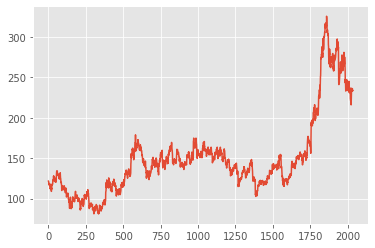

In [10]:
# Visualizing the Closing Prices
plt.plot(df_Close)

- This is how our stock price looks like from 2010 - 2018. We can that there is an overall **Increasing Trend**. 
- We now need to scale the Data as LSTMs are sensetive to this matter. For this we will be using the MinMax Scaler.

### Feature Scaling

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range= (0,1))     ## Setting the range of values to be scaled between 0 and 1.as_integer_ratio

df_Close = scaler.fit_transform(np.array(df_Close).reshape(-1,1))
print(df_Close)

[[0.16584967]
 [0.16319444]
 [0.1621732 ]
 ...
 [0.62622549]
 [0.62214052]
 [0.62418301]]


### Splitting the Dataset into Train and Test Data

- In case of Time Series Data we will divide the data with respect to Date.

In [12]:
## Train and Test Data
train_size = int(len(df_Close)*0.70)    ## Taking 70% of the Data as Train size.
test_size = len(df_Close)-train_size    ## 30% Test size.

train_data, test_data = df_Close[0:train_size,:], df_Close[train_size:len(df_Close),:]      ## Obtaining Train and Test Data.

In [13]:
## Converting to Independent and Dependent Features (based on TimeSteps)
def get_data(dataset, timestep= 1):
    Xdata, ydata = [], []
    for i in range(len(dataset) - timestep - 1):
        a = dataset[i:(i + timestep), 0]        ## This will take all the data till "i+timestep-1"
        Xdata.append(a)
        ydata.append(dataset[i + timestep, 0])  ## Here we will obtain our Output.
    return np.array(Xdata), np.array(ydata)

In the above code we are dividing our data into train and test. The process is explained as an example in the image below.
<div align= 'center'>
    <img src="https://user-images.githubusercontent.com/66016994/132118396-21e98e3f-bcfc-4431-9654-4566e548b742.png" width="700" height="200"/> 
</div>

In [14]:
## Obtaining X_train, X_test, y_train and y_test
timestep= 200
X_train, y_train = get_data(train_data, timestep= timestep)
X_test, y_test = get_data(test_data, timestep= timestep)

In [15]:
## Viewing the training Dataset
print(X_train)
print()
print()
print(y_train)

[[0.16584967 0.16319444 0.1621732  ... 0.0692402  0.0629085  0.06781046]
 [0.16319444 0.1621732  0.14971405 ... 0.0629085  0.06781046 0.0684232 ]
 [0.1621732  0.14971405 0.15400327 ... 0.06781046 0.0684232  0.07700163]
 ...
 [0.20996732 0.21098856 0.21568627 ... 0.16441993 0.15236928 0.15482026]
 [0.21098856 0.21568627 0.22079248 ... 0.15236928 0.15482026 0.15420752]
 [0.21568627 0.22079248 0.21609477 ... 0.15482026 0.15420752 0.15012255]]


[0.0684232  0.07700163 0.08088235 ... 0.15420752 0.15012255 0.15747549]


In [16]:
print(X_train.shape), print(y_train.shape)

(1223, 200)
(1223,)


(None, None)

## 3. Creating a Stacked LSTM model

In [17]:
## Reshape Input data to a 3-Dimensional data (i.e. (Observations, Timesteps) --> (Observations, Timesteps, Features)) 
## This process is very important before proceeding with the LSTM model.

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [18]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [19]:
## Create the LSTM Model
model = Sequential()

## Stacked LSTM model with 70 hidden layers.
model.add(LSTM(70, return_sequences= True, input_shape= (200,1)))
model.add(LSTM(70, return_sequences= True))
model.add(LSTM(70, return_sequences= True))
model.add(LSTM(70))

## Output Layer
model.add(Dense(1))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200, 70)           20160     
_________________________________________________________________
lstm_1 (LSTM)                (None, 200, 70)           39480     
_________________________________________________________________
lstm_2 (LSTM)                (None, 200, 70)           39480     
_________________________________________________________________
lstm_3 (LSTM)                (None, 70)                39480     
_________________________________________________________________
dense (Dense)                (None, 1)                 71        
Total params: 138,671
Trainable params: 138,671
Non-trainable params: 0
_________________________________________________________________


In [21]:
## Compile the model
model.compile(loss= 'mean_squared_error', optimizer= 'adam')

In [22]:
## Training Procedure
model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs= 100, batch_size= 64, verbose= 1)

Epoch 1/100
20/20 [==============================] - 22s 769ms/step - loss: 0.0110 - val_loss: 0.0321
Epoch 2/100
20/20 [==============================] - 14s 681ms/step - loss: 0.0021 - val_loss: 0.0130
Epoch 3/100
20/20 [==============================] - 14s 688ms/step - loss: 0.0012 - val_loss: 0.0085
Epoch 4/100
20/20 [==============================] - 14s 690ms/step - loss: 0.0011 - val_loss: 0.0086
Epoch 5/100
20/20 [==============================] - 14s 689ms/step - loss: 0.0011 - val_loss: 0.0082
Epoch 6/100
20/20 [==============================] - 14s 687ms/step - loss: 0.0010 - val_loss: 0.0077
Epoch 7/100
20/20 [==============================] - 14s 684ms/step - loss: 9.9956e-04 - val_loss: 0.0077
Epoch 8/100
20/20 [==============================] - 14s 687ms/step - loss: 9.3538e-04 - val_loss: 0.0075
Epoch 9/100
20/20 [==============================] - 14s 687ms/step - loss: 9.1084e-04 - val_loss: 0.0101
Epoch 10/100
20/20 [==============================] - 14s 694ms/step -

### Prediction on Train and Test Data

This is because we need to find the performance Matrix.

In [23]:
## Predictions
ytrain_pred = model.predict(X_train)
ytest_pred = model.predict(X_test)

In [24]:
## Transform back Scaled Data to Original Data
ytrain_pred = scaler.inverse_transform(ytrain_pred)
ytest_pred = scaler.inverse_transform(ytest_pred)

## 4. Model Results

In [25]:
## Calculating the Root Mean Square Error (Train)
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train, ytrain_pred))

136.4985522574936

In [26]:
## Calculating the Root Mean Square Error (Test)
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_test, ytest_pred))

223.66495625767024

## 5. Visualization

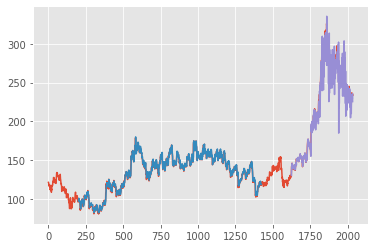

In [40]:
## Shift Train Predictions for Plotting
timestep= 200
TrainPredictPlot = np.empty_like(df_Close)
TrainPredictPlot[:, :] = np.nan
TrainPredictPlot[timestep: len(ytrain_pred) + timestep, :] = ytrain_pred

## Shift Test Predictions for Plotting
timestep= 200
TestPredictPlot = np.empty_like(df_Close)
TestPredictPlot[:, :] = np.nan
TestPredictPlot[len(ytrain_pred) + (timestep*2) + 1:len(df_Close) - 1, :] = ytest_pred

## Baseline and Predictions Plot
plt.plot(scaler.inverse_transform(df_Close))
plt.plot(TrainPredictPlot)
plt.plot(TestPredictPlot)
plt.show()

In the above plot: 
- **Red** represents the **Original Data**.
- **Blue** Represents the **Predictions** made on the **Train Data**.
- **Purple** Represents the **Predictions** made on the **Test Data**.

## 6. Future Predictions

We will now be Predicting the Future 30 days and Plot the Output

In [97]:
len(test_data), X_test.shape

(611, (410, 200, 1))

In [98]:
## Selecting the Previous 200 Days to Predict the Next Day Closing Price
Input_data = test_data[411:, :].reshape(1, -1)
Input_data.shape

(1, 200)

In [99]:
Input_data

array([[0.84763072, 0.8880719 , 0.84497549, 0.83129085, 0.8306781 ,
        0.84109477, 0.85743464, 0.89746732, 0.89828431, 0.89542484,
        0.90604575, 0.91911765, 0.91748366, 0.92177288, 0.96180556,
        0.94750817, 0.94035948, 0.94056373, 0.94485294, 0.94771242,
        0.96670752, 0.95731209, 0.95241013, 0.94914216, 1.        ,
        0.98876634, 0.96180556, 0.9501634 , 0.91707516, 0.92892157,
        0.93096405, 0.92422386, 0.9121732 , 0.9121732 , 0.90216503,
        0.91115196, 0.85661765, 0.84722222, 0.79207516, 0.78492647,
        0.75878268, 0.81372549, 0.81495098, 0.80596405, 0.83394608,
        0.82107843, 0.80923203, 0.79513889, 0.76388889, 0.74305556,
        0.75837418, 0.74019608, 0.77512255, 0.78656046, 0.79268791,
        0.79473039, 0.79207516, 0.79534314, 0.78921569, 0.76776961,
        0.78615196, 0.76552288, 0.79697712, 0.8057598 , 0.80698529,
        0.81147876, 0.78206699, 0.73386438, 0.73978758, 0.74448529,
        0.72671569, 0.72283497, 0.74040033, 0.74

In [100]:
## Converting Inputs to a List
List_Input = list(Input_data)     ## Converts 2D array to a 1D array.
List_Input = List_Input[0].tolist()   ## Converts 1D array to a list.

In [102]:
## Prediction for next 30 days
output = []
n_steps = 200
i = 0

while (i<30):

  if (len(List_Input) > 200):
    Input_data = np.array(List_Input[1:])
    print(f"{i} day input {Input_data}")
    Input_data = Input_data.reshape(1, -1)
    Input_data = Input_data.reshape((1, n_steps, 1))
    ypred = model.predict(Input_data, verbose= 0)
    print(f"{i} day output {ypred}")
    
    ## Adding Predicted value inside the Previous Data so as to have the extra elements for Future Prediction.
    List_Input.extend(ypred[0].tolist())
    List_Input = List_Input[1:]

    ## Adding Predicted value inside the Output List
    output.extend(ypred.tolist())                 
    i = i + 1

  else:
    Input_data = Input_data.reshape((1, n_steps, 1))      ## Reshaping as LSTM requires 3D Data.
    ypred = model.predict(Input_data, verbose= 0)
    print(ypred[0])

    List_Input.extend(ypred[0].tolist())
    print(len(List_Input))

    output.extend(ypred.tolist())               
    i = i + 1

print(output)

[0.6066755]
201
1 day input [0.8880719  0.84497549 0.83129085 0.8306781  0.84109477 0.85743464
 0.89746732 0.89828431 0.89542484 0.90604575 0.91911765 0.91748366
 0.92177288 0.96180556 0.94750817 0.94035948 0.94056373 0.94485294
 0.94771242 0.96670752 0.95731209 0.95241013 0.94914216 1.
 0.98876634 0.96180556 0.9501634  0.91707516 0.92892157 0.93096405
 0.92422386 0.9121732  0.9121732  0.90216503 0.91115196 0.85661765
 0.84722222 0.79207516 0.78492647 0.75878268 0.81372549 0.81495098
 0.80596405 0.83394608 0.82107843 0.80923203 0.79513889 0.76388889
 0.74305556 0.75837418 0.74019608 0.77512255 0.78656046 0.79268791
 0.79473039 0.79207516 0.79534314 0.78921569 0.76776961 0.78615196
 0.76552288 0.79697712 0.8057598  0.80698529 0.81147876 0.78206699
 0.73386438 0.73978758 0.74448529 0.72671569 0.72283497 0.74040033
 0.74693627 0.72630719 0.80065359 0.79187092 0.77328431 0.78451797
 0.78329248 0.80412582 0.79473039 0.7879902  0.7879902  0.79473039
 0.81168301 0.81699346 0.82986111 0.838439

In [103]:
New_Day = np.arange(1,201)
Pred_Day = np.arange(201, 231)

In [104]:
len(df_Close)

2035

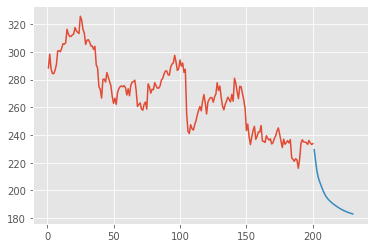

In [105]:
plt.plot(New_Day, scaler.inverse_transform(df_Close[1835:]))    ## 2035-200 = 1835
plt.plot(Pred_Day, scaler.inverse_transform(output))